深度學習與電腦視覺馬拉松期末專題

In [1]:
import tensorflow as tf
import numpy as np
import sys
import os
print('tensorflow version:', tf.__version__)
print('python version:', sys.version)

tensorflow version: 1.15.0
python version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 7.9MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
%cd '/content/gdrive/My Drive/Colab Notebooks/'
# %ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [0]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()
# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")
# 資料集目錄
DATA_SET_PATH = os.path.join(DATA_PATH, "raccoon_dataset")
# 資料集標註檔目錄
ANNOTATIONS_PATH = os.path.join(DATA_SET_PATH, "annotations")
# 資料集圖像檔目錄
IMAGES_PATH = os.path.join(DATA_SET_PATH, "images")
# 
CSV_PATH = os.path.join(DATA_SET_PATH, "data")

In [5]:
print(ROOT_DIR)
print(DATA_PATH)
print(DATA_SET_PATH)
print(ANNOTATIONS_PATH)
print(IMAGES_PATH)
print(CSV_PATH)

/content/gdrive/My Drive/Colab Notebooks
/content/gdrive/My Drive/Colab Notebooks/data
/content/gdrive/My Drive/Colab Notebooks/data/raccoon_dataset
/content/gdrive/My Drive/Colab Notebooks/data/raccoon_dataset/annotations
/content/gdrive/My Drive/Colab Notebooks/data/raccoon_dataset/images
/content/gdrive/My Drive/Colab Notebooks/data/raccoon_dataset/data


In [0]:
# 將資料集格式轉為yolo3吃的格式
import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library

#設定XML檔(label)和圖片檔(image)的資料夾路徑
labelpath = 'data/raccoon_dataset/annotations' 
imagepath = 'data/raccoon_dataset/images' 

#取得所有XML檔的檔名
labelnames = os.listdir(labelpath)

#在當前資料夾建立一個 train.txt檔 用來存圖片的框選資訊
Tfile = open('train.txt','w')

#遍歷每個XML檔 統合所有資訊
#目標 做出以下格式的train.txt檔: image_file_path box1 box2 ... boxN
#其中box格式為: x_min,y_min,x_max,y_max,class_id 
for labelfile in labelnames:
    #接出XML檔案路徑 和 圖檔路徑
    XMLpath = labelpath + '/' + labelfile
    PICpath = imagepath + '/' + labelfile[0:-3] + 'jpg' ###這裡我把附檔名'xml'去掉 改成圖檔的副檔名'jpg'
    
    #寫入每一列的第一筆資訊 --- image_file_path
    Tfile.write(PICpath)
    
    #開啟XML檔 讀取資訊
    with open(XMLpath) as in_file:
        tree = ET.parse(in_file)
        root = tree.getroot()
        
        #找出每個object結構 一個object代表一筆標記框訊息
        for obj in root.iter('object'):
            #bndbox結構是存位置資訊的地方
            bbx = obj.find('bndbox')
            #寫入標記框的資訊
            Tfile.write(' ' + bbx.find('xmin').text + 
                        ',' + bbx.find('ymin').text + 
                        ',' + bbx.find('xmax').text + 
                        ',' + bbx.find('xmax').text
                       )
            #我把袋鼠class_id設為0 浣熊class_id為1
            if(obj.find('name').text == 'kangaroo'):
                Tfile.write(',0')
            else:
                Tfile.write(',1')
    #一個XML檔的所有資料在train.txt中寫成一列 故每個XML檔讀完後要換行
    Tfile.write('\n')
#全都寫完後關閉train.txt           
Tfile.close()

In [7]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

%cd keras-yolo3-master
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper
%cd "/content/gdrive/My Drive/Colab Notebooks/"

Using TensorFlow backend.


/content/gdrive/My Drive/Colab Notebooks/keras-yolo3-master
/content/gdrive/My Drive/Colab Notebooks


In [0]:
# !wget https://pjreddie.com/media/files/yolov3.weights

--2020-02-27 16:27:43--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   524KB/s    in 14m 24s 

2020-02-27 16:42:08 (280 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [8]:
if not os.path.exists("keras-yolo3-master/model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [9]:
!nvidia-smi

Sun Mar  1 13:20:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES =True

annotation_path = 'train.txt' # 轉換好格式的標註檔案 --> 剛剛的train.txt 我改名成final_train.txt
log_dir = '/content/gdrive/My Drive/Colab Notebooks/logs/day50/' # 訓練好的模型儲存的路徑 從000改成001 換個名字 不跟作業41的重複
classes_path = '/content/gdrive/My Drive/Colab Notebooks/keras-yolo3-master/model_data/animal_classes.txt' #自己照voc_classes.txt寫一個final_classes.txt 裡面放訓練的種類名稱 照class_id的順續放
anchors_path = '/content/gdrive/My Drive/Colab Notebooks/keras-yolo3-master/model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='keras-yolo3-master/model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='keras-yolo3-master/model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=0,
            callbacks=[checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')














Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights keras-yolo3-master/model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 180 samples, val on 20 samples, with batch size 16.


Epoch 1/100
11/11 [==============================] - 76s 7s/step - loss: 8603.7315 - val_loss: 4714.3613
Epoch 2/100
11/11 [==============================] - 12s 1s/step - loss: 2695.5438 - val_loss: 1574.7183
Epoch 3/100
11/11 [==============================] - 12s 1s/step - loss: 1000.1617 - val_loss: 650.1091
Epoch 4/100
11/11 [==============================] - 3s 250ms/step - loss: 519.6982 - val_loss: 419.6361
Epoch 5/100
11/11 [==============================] - 11s 984ms/step - loss: 349.3861 - val_loss: 296.3894
Epoch 6/100
11/11 [==============================] - 12s 1s/step - loss: 278.0204 - val_loss: 237.7221
Epoch 7/100
11/11 [==============================] - 12s 1s/step - loss: 225.3225 - val_loss: 222.4137
E

In [11]:
from PIL import Image
%cd 'gdrive/My Drive/Colab Notebooks'
image = Image.open('raccoon-test.jpg')

[Errno 2] No such file or directory: 'gdrive/My Drive/Colab Notebooks'
/content/gdrive/My Drive/Colab Notebooks


In [12]:
%cd keras-yolo3-master
from yolo import YOLO

/content/gdrive/My Drive/Colab Notebooks/keras-yolo3-master


/content/gdrive/My Drive/Colab Notebooks/logs/day50/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (12, 12) (720, 480)
2.693382226999802


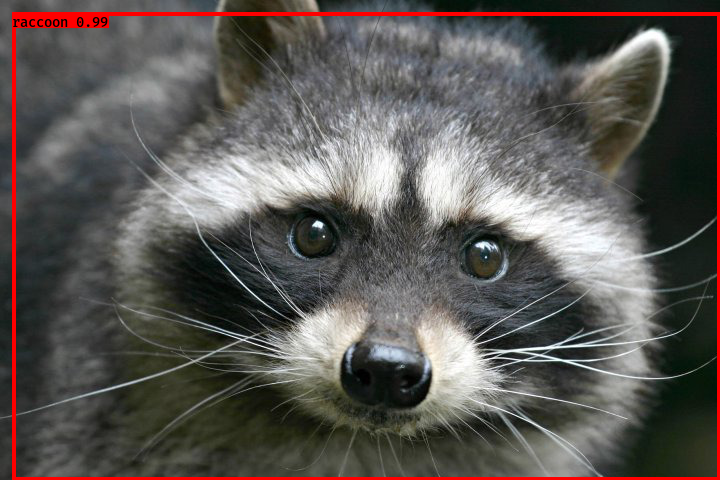

In [13]:
log_dir="/content/gdrive/My Drive/Colab Notebooks/logs/day50/"
classes_path = '/content/gdrive/My Drive/Colab Notebooks/keras-yolo3-master/model_data/animal_classes.txt'
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)
r_image

In [14]:
import cv2
import numpy as np
from PIL import Image
import timeit
log_dir="/content/gdrive/My Drive/Colab Notebooks/logs/day50/"
classes_path = '/content/gdrive/My Drive/Colab Notebooks/keras-yolo3-master/model_data/animal_classes.txt'
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

starttime = timeit.default_timer()
cap = cv2.VideoCapture('raccoon.mp4')

# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 值為 30.0，解析度為 1280*720
out = cv2.VideoWriter('raccoon-detection.avi', fourcc, 30.0, (1280, 720))

k = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        out.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
cap.release()
out.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

/content/gdrive/My Drive/Colab Notebooks/logs/day50/trained_weights_final.h5 model, anchors, and classes loaded.
共耗時: 0.18 秒，FPS: 0.0
